# **Segmentation Analysis**:<a class="anchor" id="0"></a>

1. [**Data Import**](#1)
2. [**Segmentation**](#2)

In [16]:
import numpy as np
import pandas as pd

from _util.custom_plotting import *
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from _util.custom_mem_opt import custom_mem_opt

sns.set_style('darkgrid')
color = sns.color_palette()

pd.options.mode.chained_assignment = None  # default='warn'

root = './_data/'

### Data Import <a class=anchor id="1"></a>
[Back to top](#0)

In [3]:
aisles = custom_mem_opt(pd.read_csv(root + 'aisles.csv'), verbose=False)
departments = custom_mem_opt(pd.read_csv(root + 'departments.csv'), verbose=False)
orders = custom_mem_opt(pd.read_csv(root + 'orders.csv'), verbose=False)
order_products_prior = custom_mem_opt(pd.read_csv(root + 'order_products__prior.csv'), verbose=False)
order_products_train = custom_mem_opt(pd.read_csv(root + 'order_products__train.csv'), verbose=False)
products = custom_mem_opt(pd.read_csv(root + 'products.csv'), verbose=False)

In [4]:
# Focus on customers in prior set.
order_products = order_products_prior.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')
print(order_products.shape)

(32434489, 15)


In [5]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [6]:
print(order_products.user_id.nunique())

206209


### Segmentation <a class=anchor id="2"></a>
[Back to top](#0)

Going to use PCA on aisles to mitigate dimensionality of the data.

In [7]:
ct = pd.crosstab(order_products.user_id, order_products.aisle)
ct.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,12,0,0,0,0,5,0,11,0,0,0,0,0,0,0,...,0,1,0,0,3,0,0,1,0,10,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,...,0,0,0,0,14,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [8]:
# Normalize
df = ct.div(ct.sum(axis=1), axis=0)
df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.016949,0.0,0.000000,0.0,0.000000,0.0,0.050847,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.033898,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.033898,0.0,0.000000,0.000000,0.203390,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.220339,0.000000,0.033898,0.0,0.000000,0.0,0.0,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,0.0,0.005128,0.005128,0.010256,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.005128,0.0,0.000000,0.061538,0.0,0.0,0.0,0.0,0.025641,0.0,0.056410,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.005128,0.0,0.0,0.015385,0.000000,0.0,0.005128,0.000000,0.051282,0.0,0.000000,0.005128,0.0,0.0,0.000000,0.025641,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.005128,0.0,0.000000,0.0,0.0,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.068182,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.159091,0.011364,0.0,0.000000,0.000000,0.000000,0.0,0.022727,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.170455,0.0,0.000000,0.0,0.0,0.045455,0.011364,0.000000,0.000000,0.0,0.0,0.0,0.022727,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.055556,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.055556,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.055556,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.055556,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.055556,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.055556,0.000000,0.0,0.055556,0.0,0.0,0.000000,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.055556,0.0,0.000000
5,0.0,0.054054,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.027027,0.0,0.000000,0.0,0.000000,0.027027,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.216216,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.081081


In [9]:
print(df.shape)

(206209, 134)


#### PCA and K-Means Clustering

Reducing dimensionality to facilitate k-means.

In [10]:
pca = PCA(n_components=10)
pca_df = pca.fit_transform(df)
pca_df = pd.DataFrame(pca_df)
pca_df.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.113443,0.039084,-0.042863,0.018866,-0.088336,-0.104593,-0.116550,0.083557,-0.061624,-0.024223
1,-0.036988,0.108884,-0.066406,-0.123271,0.098849,-0.033964,-0.054743,-0.053387,-0.020266,-0.008123
2,0.064282,0.103962,0.000710,-0.012221,-0.046978,0.112209,-0.029872,0.007802,0.012933,0.002571
3,-0.093210,0.054093,0.001867,-0.003974,-0.071358,-0.019268,-0.025110,-0.038212,0.006262,-0.000653
4,0.094629,-0.037051,-0.024952,-0.021574,0.055370,0.107640,-0.008045,0.103859,0.051936,-0.025774


In [11]:
ssd = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(pca_df)
    ssd.append(km.inertia_)

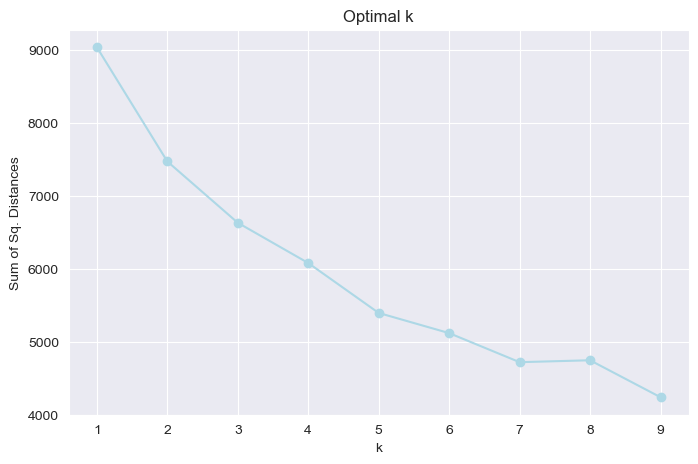

In [12]:
plt.subplots(figsize = (8, 5))
plt.plot(K, ssd, marker='o', color='lightblue')
plt.xlabel('k')
plt.ylabel('Sum of Sq. Distances')
plt.title('Optimal k')
plt.show()

We'll go with k=5 from the plot.

In [14]:
clusterer = KMeans(n_clusters=5,random_state=42).fit(pca_df)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(pca_df)
print(centers)

[[ 1.05540564e-01 -7.30796005e-02  1.72527836e-02  3.67287251e-03
   1.76852005e-03 -4.43209135e-03 -9.45921192e-04  1.29287778e-03
  -1.66012344e-04  7.79898561e-04]
 [-1.98274645e-01  1.61778113e-02  3.17235433e-01 -3.14083043e-02
   1.87339365e-02  6.18845562e-04  4.05918230e-03  1.08906688e-02
   1.13907813e-03 -3.84654752e-03]
 [ 6.75921197e-02  1.05887337e-01 -1.11715645e-03 -3.09336564e-02
  -1.07423699e-02  7.19464819e-03 -5.25193981e-04  4.51245261e-03
  -7.20153875e-04 -1.68754796e-04]
 [-7.39021851e-02 -1.05746652e-02 -2.70097327e-02 -7.00804730e-03
  -6.75429167e-03  1.54531494e-03  5.03896363e-04 -2.53080340e-03
  -3.19892047e-04 -4.10643380e-04]
 [-6.14889646e-03  1.30669687e-01  4.84365828e-03  2.30157724e-01
   1.10159849e-01 -2.27802274e-02  9.32698628e-05 -6.40143184e-03
   7.80621020e-03  3.06617054e-03]]


In [17]:
temp_df = pca_df.iloc[:, 0:2]
temp_df.columns = ["pc1", "pc2"]
temp_df['cluster'] = c_preds
temp_df.head()

,pc1,pc2,cluster
0,-0.113443,0.039084,3
1,-0.036988,0.108884,2
2,0.064282,0.103962,2
3,-0.093210,0.054093,3
4,0.094629,-0.037051,0


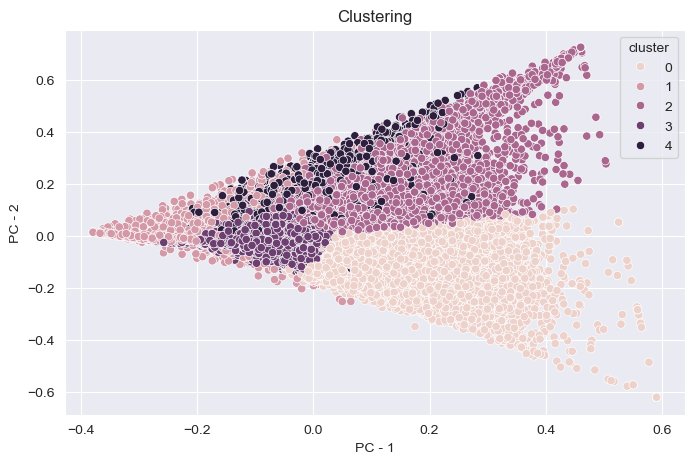

In [18]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2", hue = "cluster")
ax.set_xlabel("PC - 1")
ax.set_ylabel("PC - 2")
ax.set_title("Clustering")
plt.show()

### Top Products x Cluster

In [20]:
ct['cluster'] = c_preds

cluster1 = ct[ct.cluster == 0]
cluster2 = ct[ct.cluster == 1]
cluster3 = ct[ct.cluster == 2]
cluster4 = ct[ct.cluster == 3]
cluster5 = ct[ct.cluster == 4]

In [21]:
print(cluster1.shape)

(55838, 135)


In [22]:
print(cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10])

aisle
fresh vegetables                 37.034582
fresh fruits                     21.747627
packaged vegetables fruits       12.027454
yogurt                            6.160984
packaged cheese                   5.019395
fresh herbs                       4.150901
milk                              4.003815
soy lactosefree                   3.705989
frozen produce                    3.302608
water seltzer sparkling water     3.080178
dtype: float64


In [31]:
print(cluster2.shape)

(5414, 135)


In [24]:
print(cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10])

aisle
water seltzer sparkling water    20.950683
fresh fruits                      3.336535
soft drinks                       2.800702
yogurt                            2.254895
energy granola bars               1.557074
chips pretzels                    1.346694
milk                              1.327484
tea                               1.327115
packaged vegetables fruits        1.251201
soy lactosefree                   1.082564
dtype: float64


In [25]:
print(cluster3.shape)

(37866, 135)


In [26]:
print(cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10])

aisle
fresh fruits                     35.763614
fresh vegetables                 15.034807
packaged vegetables fruits       12.100592
yogurt                            9.883933
milk                              5.957772
packaged cheese                   5.113268
soy lactosefree                   3.777082
water seltzer sparkling water     3.614007
bread                             3.196746
chips pretzels                    3.130645
dtype: float64


In [27]:
print(cluster4.shape)

(99143, 135)


In [28]:
print(cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10])

aisle
fresh fruits                     9.775103
fresh vegetables                 7.574292
yogurt                           7.223112
packaged vegetables fruits       6.001755
packaged cheese                  4.931442
chips pretzels                   4.482263
milk                             4.254773
water seltzer sparkling water    4.091444
refrigerated                     3.257124
ice cream ice                    3.098444
dtype: float64


In [29]:
print(cluster5.shape)

(7948, 135)


In [30]:
print(cluster5.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10])

aisle
packaged produce                 18.356442
fresh fruits                     10.873427
packaged vegetables fruits        4.242199
fresh vegetables                  3.108455
water seltzer sparkling water     1.714771
milk                              1.614872
packaged cheese                   1.548691
frozen produce                    1.144942
chips pretzels                    1.139280
nuts seeds dried fruit            1.033090
dtype: float64


- Cluster 1 includes 55838 consumers who exhibit preferences for fresh vegetables followed by fruits.
- Cluster 2 includes 5414 consumers who exhibit preferences for water seltzer sparkling water aisle.
- Cluster 3 includes 37866 consumers who exhibit preferences for fruits followed and fresh vegetables.
- Cluster 4 includes 99143 consumers who don't exhibit clear preferences for any category. Their average orders are relatively low, so either they don't use Instacart regularly or they are new. 
- Cluster 5 includes 7948 consumers  who exhibit preferences for packaged produce and fresh fruits.

